# Style Transfer
* VGG Modelを使用する。

In [19]:
!python --version
!nvcc --version

Python 3.7.15
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [20]:
!pip install torch torchvision
!pip install Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
%matplotlib inline
import torch
import torch.optim as optim
from torchvision import transforms, models

from pathlib import Path
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np

In [22]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# デバイス確認

In [23]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
  param.requires_grad_(False)

device = torch.device("gpu" if torch.cuda.is_available() else "cpu")
print(f'you device to {device}')
vgg.to(device)

you device to cpu


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

# 画像の表示

In [24]:
def load_image(image_path, max_size=600, shape=None):
  # RGBに変換
  image = Image.open(image_path).convert('RGB')
  # width or heightが引数以上なら、sizeに引数のmax_sizeを代入する
  # それ以外なら、sizeにwidth or heightの最大値を代入する
  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)

  # Tensorに変換を行う
  if shape:
    size = shape
  in_transform = transforms.Compose([
      transforms.Resize(size),
      transforms.ToTensor(),
  ])

  image = in_transform(image).unsqueeze(0)

  return image

In [25]:
image_path_str = '/content/gdrive/MyDrive/Colab_Notebooks/DeepL_test_data/test_data/test_data_himmel'
images_path = Path(image_path_str)

# style_image_path = 'lily.jpg'
style_image_path = 'lily.jpg'
style_image = Path(images_path, style_image_path)

content_image_path = 'himmel.jpg'
content_image = Path(images_path, content_image_path)

content = load_image(content_image)
style = load_image(style_image)

(-0.5, 599.5, 799.5, -0.5)

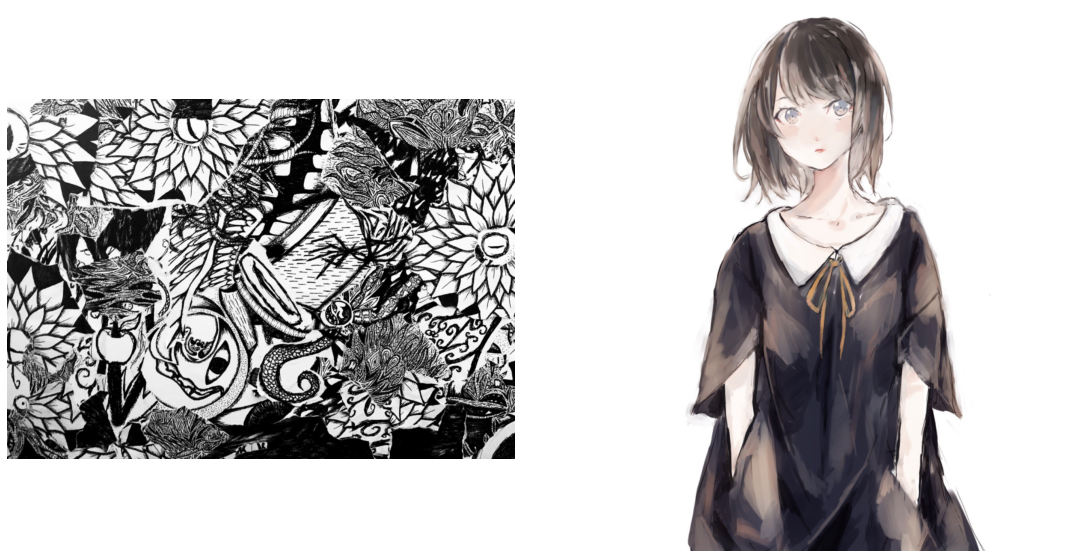

In [26]:
def image_convert(tensor):
  #Tensorをnp.arrayに変換する
  image = tensor.to("cpu").clone().detach()
  # tensor を np に戻し、画像表示できるようにする
  image = image.numpy().squeeze()
  image = image.transpose(1,2,0)
  image = image * np.array((0.5, 0.5, 0.5) + np.array((0.5, 0.5, 0.5)))
  image = image.clip(0, 1)
  
  return image

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(image_convert(style))
ax1.axis("off")
ax2.imshow(image_convert(content))
ax2.axis("off")

In [27]:
#   特徴を抜き出すレイヤー
layers = {
      '0': 'conv1_1',
      '5': 'conv2_1',
      '10': 'conv3_1',
      '19': 'conv4_1',
      '21': 'conv4_2',
      '28': 'conv5_1'
}

# 比較する層の重みを設定する
style_weights = {'conv1_1':1.,
                 'conv2_1':0.75,
                 'conv3_1':0.2,
                 'conv4_1':0.2,
                 'conv5_1':0.2}

# 特徴の抽出
　* CNNを用いての特徴抽出を行う

  * 参考: https://harkerhack.com/pytorch-style-transfer/#PytorchStyleTransfer

```
  CNNは大きく二つの層に分かれます。画像から特徴を抜き出す前半の層と、抜き出した特徴から画像を最終的に分類する後半の層です。

二つの画像の特徴をCNNで抽出し、その特徴の差を損失関数にして最終的な画像を学習させます。
そのために画像をCNNに入れて、特定の層で特徴を抽出しましょう。
VGGの
0番、
5番、
10番、
19番、
21番、
28番目
の層で抽出します。

まず関数の定義です。
```

# CNNを廻す

In [28]:
def get_features(image, model):
#   Feature Extraction
  features = {}
  
  for name, layer in model._modules.items():
    # CNNを回して
    image = layer(image)
    # 特定のレイヤーで特徴を抽出する
    # ここでは　0番　5番　10番　19番　21番　28番
    if name in layers:
      features[layers[name]] = image
      
  return features

# ここらへんからわからない

In [29]:
# 特徴を抽出する
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

In [30]:
def gram_matrix(tensor):
  #   グラム行列を計算する
  _, d, h, w = tensor.size()
  tensor = tensor.view(d, h * w)
#   転置行列と行列の掛け算
  gram = torch.mm(tensor, tensor.t())
  
  return gram

In [31]:
# スタイルのグラム行列を保持する
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

In [32]:
# alpha
content_weight = 1
# blue
style_weight = 1e6

In [33]:
# contentの画像をコピーして学習させていくのでコピーし、targetとして定義する
target = content.clone().requires_grad_(True).to(device)

# 学習

* HyperParameter

In [34]:
# n回ごとにすべて表示
show_every = 10
# Optimizer(最適化アルゴリズム)
# init 0.003
optimizer = optim.Adam([target], lr=0.005)
# 何回繰り返すか
# init 10000
steps = 500
# 総キャプチャーフレーム数
total_capture_frame_number = 250

# 画像のshapeを表示
height, width, channels = image_convert(target).shape
image_array = np.empty(shape=(total_capture_frame_number, height, width, channels))
capture_frame = steps / total_capture_frame_number
counter = 0

* 学習の実行

Total loss:  217126384.0
Iteration:  10


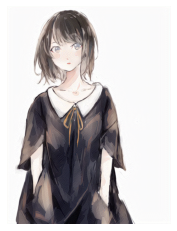

Total loss:  140448992.0
Iteration:  20


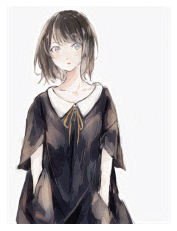

Total loss:  93846072.0
Iteration:  30


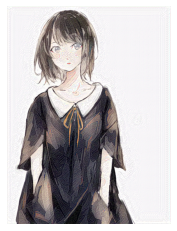

Total loss:  67162632.0
Iteration:  40


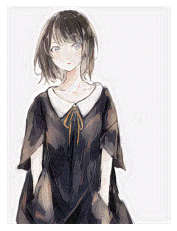

Total loss:  50984556.0
Iteration:  50


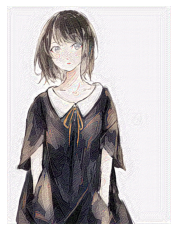

Total loss:  40447876.0
Iteration:  60


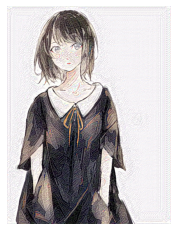

Total loss:  33340158.0
Iteration:  70


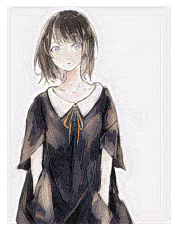

Total loss:  28228344.0
Iteration:  80


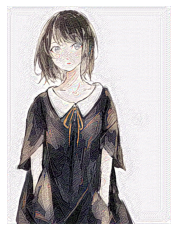

Total loss:  24337918.0
Iteration:  90


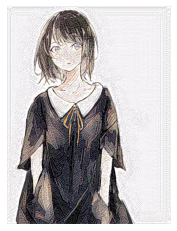

Total loss:  21277714.0
Iteration:  100


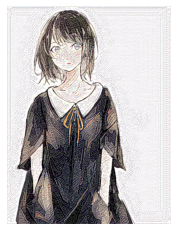

Total loss:  18811718.0
Iteration:  110


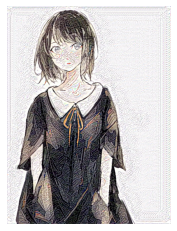

Total loss:  16783132.0
Iteration:  120


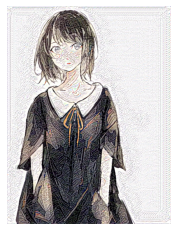

Total loss:  15089684.0
Iteration:  130


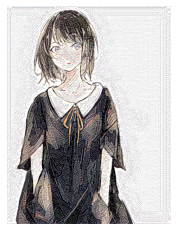

Total loss:  13659765.0
Iteration:  140


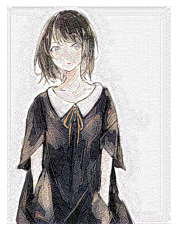

Total loss:  12438813.0
Iteration:  150


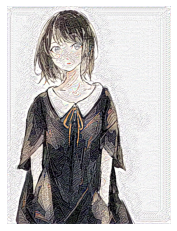

Total loss:  11386106.0
Iteration:  160


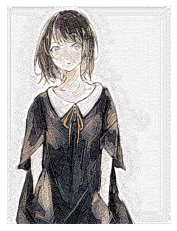

Total loss:  10471209.0
Iteration:  170


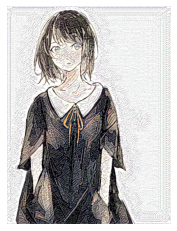

Total loss:  9670748.0
Iteration:  180


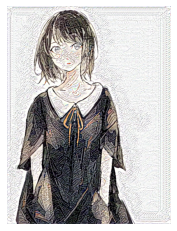

Total loss:  8965747.0
Iteration:  190


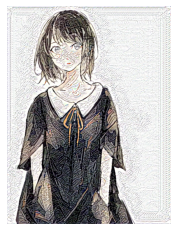

Total loss:  8339681.5
Iteration:  200


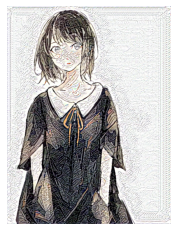

In [ ]:
for ii in range(1, steps+1):
  # targetの特徴レイヤーを抜き出す。
  target_features = get_features(target, vgg)
  # コンテンツとの損失関数の計算
  # TODO: なぜ、target[4_2] - content[4_2] ** 2 [二乗しているのは、二乗和誤差]
  content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)

  # スタイルとの損失関数の計算
  style_loss = 0

  for layer in style_weights:
    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)
    style_gram = style_grams[layer]

    # 重み * 二乗和誤差
    layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)
    _, d, h, w = target_feature.shape
    style_loss += layer_style_loss / (d * h * w)
  
  # トータルの損失関数
  total_loss = content_weight * content_loss + style_weight * style_loss
  
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()
  
  # 経過観察
  if ii % show_every == 0:
    print('Total loss: ', total_loss.item())
    print('Iteration: ', ii)
    plt.imshow(image_convert(target))
    plt.axis("off")
    plt.show()
    
  # 動画用に保管
  if ii % capture_frame == 0:
    image_array[counter] = image_convert(target)
    counter = counter + 1